In [1]:
# !pip install transformers

In [24]:
import os
import sys
import glob
import shutil
import zipfile
import subprocess
import pandas as pd

In [25]:
LANG = "python"
MODEL_TYPE = "roberta"
PRETRAINED_MODEL = "microsoft/codebert-base"

N_EPOCHS = 1
LEARNING_RATE = 5e-5

BEAM_SIZE = 10
MAX_SOURCE_LEN = 256
MAX_TARGET_LEN = 128

BATCH_SIZE_EVAL = 50
BATCH_SIZE_TRAIN = 10

MINI_DATASET_SIZE = 50
MINI_MODE_ENABLED = True

FILENAME_JSONL_TEST = "test.jsonl"
FILENAME_JSONL_TRAIN = "train.jsonl"
FILENAME_JSONL_VALID = "valid.jsonl"

FILENAME_JSONL_TEST_MINI = "test-mini.jsonl"
FILENAME_JSONL_TRAIN_MINI = "train-mini.jsonl"
FILENAME_JSONL_VALID_MINI = "valid-mini.jsonl"

FILENAME_CSV_TRAIN_LOSS = "train_loss.csv"

PLT_FIG_SIZE: int = (2 * 2 * 2 * 3, 2 * 2 * 3)

In [28]:
notebook_path = os.path.abspath(os.curdir)
root_path = os.path.dirname(notebook_path)

repo_path = os.path.join(root_path, "repos", "CodeXGLUE")
task_path = os.path.join(repo_path, "Code-Text", "code-to-text")

src_path = os.path.join(root_path, "src", "python")
src_task_path = os.path.join(src_path, "codexglue", "summarization")

code_path = os.path.join(task_path, "code")
dataset_path = os.path.join(task_path, "dataset")
evaluator_path = os.path.join(task_path, "evaluator")

model_path = os.path.join(notebook_path, "model")

model_name = "lang={lang}-model_type={model_type}-pretrained_model={pretrained_model}" \
    .format(
        lang=LANG
        , model_type=MODEL_TYPE
        , pretrained_model=PRETRAINED_MODEL.replace("/", "_").replace("-", "_")
    )

In [34]:
shutil.copy(
    src=os.path.join(src_path, "utils.py")
    , dst=os.path.join(notebook_path)
)

shutil.copy(
    src=os.path.join(src_path, "iteration_data_point.py")
    , dst=os.path.join(notebook_path)
)

'/Users/kaveh/repos/CS5814-project/dataset=codexglue-task=summarization-lang=python-model_type=roberta-pretrained_model=codebert/iteration_data_point.py'

In [33]:
if not os.path.exists(repo_path):
    os.makedirs(repo_path, exist_ok=True)
    
    subprocess.check_call(
        [
            "git"
            , "clone"
            , "https://github.com/microsoft/CodeXGLUE"
            , repo_path
        ]
    )

shutil.copy(
    src=os.path.join(src_path, "iteration_data_point.py")
    , dst=os.path.join(code_path)
)

shutil.copy(
    src=os.path.join(src_task_path, "run.py")
    , dst=os.path.join(code_path, "run.py")
)

'/Users/kaveh/repos/CS5814-project/repos/CodeXGLUE/Code-Text/code-to-text/code/run.py'

In [32]:
if not os.path.exists(dataset_path):
    with zipfile.ZipFile(os.path.join(task_path, "dataset.zip"), 'r') as dataset_zip_file:
        dataset_zip_file.extractall(task_path)

    for lang in ["python", "java", "ruby", "javascript", "go", "php"]:
        subprocess.check_call(
            [
                "wget"
                , "https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/{lang}.zip".format(lang=lang)
                , "-P"
                , dataset_path
            ]
        )

        with zipfile.ZipFile(os.path.join(dataset_path, "{lang}.zip".format(lang=lang)), 'r') as lang_zip_file:
            lang_zip_file.extractall(dataset_path)
    
    os.chdir(dataset_path)
    subprocess.check_call(
        [
            "python"
            , os.path.join(dataset_path, "preprocess.py")
        ]
    )
    os.chdir(root_path)

    [os.remove(f) for f in glob.glob(os.path.join(dataset_path, "*.zip"))]
    [os.remove(f) for f in glob.glob(os.path.join(dataset_path, "*.pkl"))]
    [shutil.rmtree(dir, ignore_errors=True) for dir in glob.glob(os.path.join(dataset_path, "*/final"))]

    for lang in ["python", "java"]:
        with open(os.path.join(dataset_path, lang, FILENAME_JSONL_TRAIN), mode="r") as f:
            with open(os.path.join(dataset_path, lang, FILENAME_JSONL_TRAIN_MINI), mode="a") as mini_f:
                for i in range(MINI_DATASET_SIZE):
                    mini_f.write(next(f))

        with open(os.path.join(dataset_path, lang, FILENAME_JSONL_VALID), mode="r") as f:
            with open(os.path.join(dataset_path, lang, FILENAME_JSONL_VALID_MINI), mode="a") as mini_f:
                for i in range(MINI_DATASET_SIZE):
                    mini_f.write(next(f))

        with open(os.path.join(dataset_path, lang, FILENAME_JSONL_TEST), mode="r") as f:
            with open(os.path.join(dataset_path, lang, FILENAME_JSONL_TEST_MINI), mode="a") as mini_f:
                for i in range(MINI_DATASET_SIZE):
                    mini_f.write(next(f))

if os.path.exists(path=os.path.join(model_path)):
    shutil.rmtree(
        ignore_errors=True
        , path=os.path.join(model_path)
    )

'/Users/kaveh/repos/CS5814-project/repos/CodeXGLUE/Code-Text/code-to-text/code/iteration_data_point.py'

In [23]:
subprocess.check_call(
    [
        "python"
        
        , os.path.join(code_path, "run.py")
        
        , "--model_type", MODEL_TYPE
        , "--model_name_or_path", PRETRAINED_MODEL
        , "--output_dir", model_path
        
        , "--num_train_epochs", str(N_EPOCHS)
        , "--learning_rate", str(LEARNING_RATE)

        , "--beam_size", str(BEAM_SIZE)
        , "--max_source_length", str(MAX_SOURCE_LEN)
        , "--max_target_length", str(MAX_TARGET_LEN)

        , "--do_train"
        , "--train_batch_size", str(BATCH_SIZE_TRAIN)
        , "--train_filename", os.path.join(
            dataset_path
            , LANG
            , FILENAME_JSONL_TRAIN if not MINI_MODE_ENABLED else FILENAME_JSONL_TRAIN_MINI
        )

        , "--do_eval"
        , "--eval_batch_size", str(BATCH_SIZE_EVAL)
        , "--dev_filename", os.path.join(
            dataset_path
            , LANG
            , FILENAME_JSONL_VALID if not MINI_MODE_ENABLED else FILENAME_JSONL_VALID_MINI
        )

        , "--train_loss_csv_filename", os.path.join(model_path, FILENAME_CSV_TRAIN_LOSS)
    ]
)

05/04/2022 22:44:04 - INFO - __main__ -   Namespace(adam_epsilon=1e-08, beam_size=10, config_name='', dev_filename='/Users/kaveh/repos/CS5814-project/repos/CodeXGLUE/Code-Text/code-to-text/dataset/python/valid-mini.jsonl', do_eval=True, do_lower_case=False, do_test=False, do_train=True, eval_batch_size=50, eval_steps=-1, gradient_accumulation_steps=1, learning_rate=5e-05, load_model_path=None, local_rank=-1, max_grad_norm=1.0, max_source_length=256, max_steps=-1, max_target_length=128, model_name_or_path='microsoft/codebert-base', model_type='roberta', no_cuda=False, num_train_epochs=1, output_dir='/Users/kaveh/repos/CS5814-project/dataset=codexglue-task=summarization-lang=python-model_type=roberta-pretrained_model=codebert/model', seed=42, test_filename=None, tokenizer_name='', train_batch_size=10, train_filename='/Users/kaveh/repos/CS5814-project/repos/CodeXGLUE/Code-Text/code-to-text/dataset/python/train-mini.jsonl', train_loss_csv_filename='/Users/kaveh/repos/CS5814-project/dataset

0

ValueError: range() arg 3 must not be zero

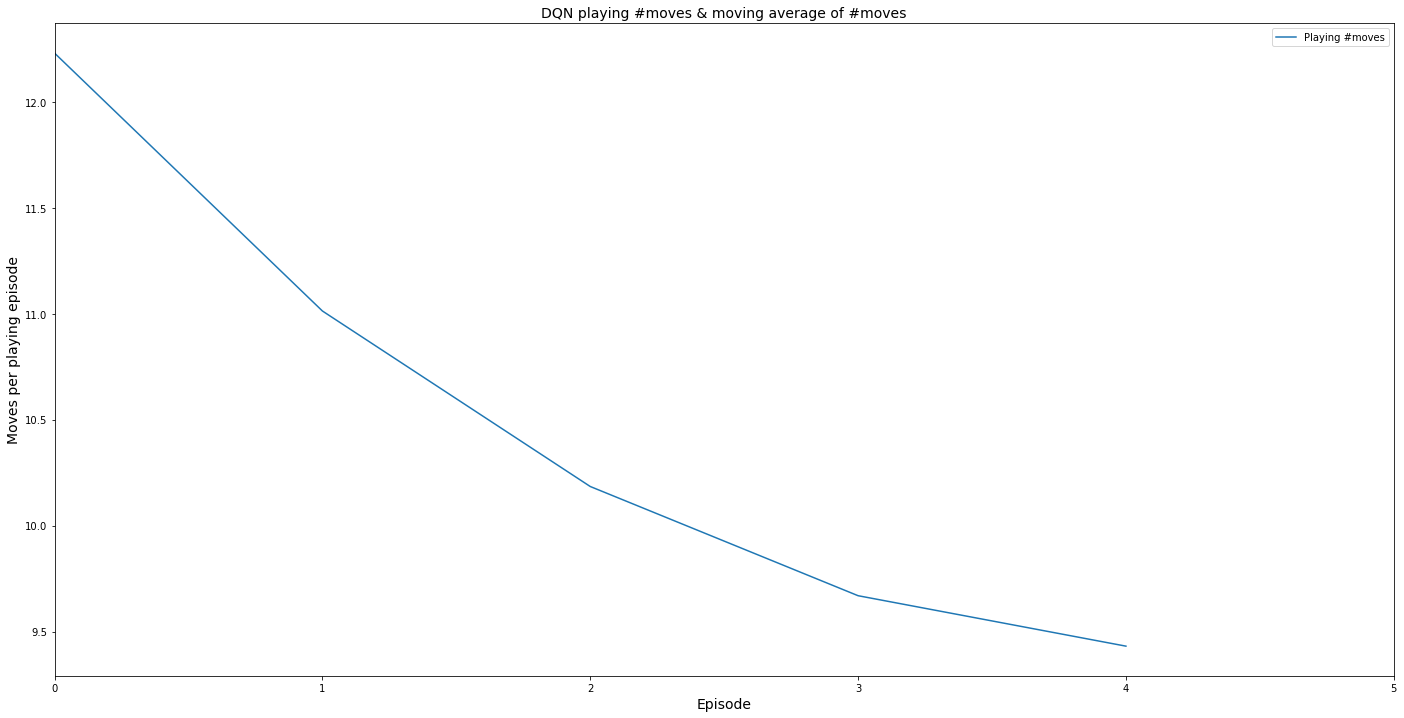

In [27]:
from utils import Utils
from iteration_data_point import IterationDataPoint

R = pd.read_csv(os.path.join(model_path, FILENAME_CSV_TRAIN_LOSS))

Utils.multiline_plot(
    xs=R[IterationDataPoint.COL_NAME_ITER_IDX]
    , fig_size=PLT_FIG_SIZE
    , x_axis_label="Iterations"
    , y_axis_label="Training Loss"
    , title=model_name
    , y_legends=["Training Loss"]
    , yss=[
        R[IterationDataPoint.COL_NAME_LOSS]
    ]
)

In [ ]:
subprocess.check_call(
    [
        "python"
        
        , os.path.join(code_path, "run.py")
        
        , "--model_type", MODEL_TYPE
        , "--model_name_or_path", PRETRAINED_MODEL
        , "--output_dir", model_path
        , "--load_model_path", os.path.join(model_path, "checkpoint-best-bleu", "pytorch_model.bin")

        , "--beam_size", str(BEAM_SIZE)
        , "--max_source_length", str(MAX_SOURCE_LEN)
        , "--max_target_length", str(MAX_TARGET_LEN)

        , "--do_test"
        , "--test_filename", os.path.join(
            dataset_path
            , LANG
            , FILENAME_JSONL_TEST if not MINI_MODE_ENABLED else FILENAME_JSONL_TEST_MINI
        )
    ]
)

In [ ]:
os.chdir(evaluator_path)

subprocess.check_call(
    [
        "python"
        , "evaluator.py"
        , os.path.join(model_path, model_name, "test_0.gold")
        , "<"
        , os.path.join(model_path, model_name, "test_0.output")
    ]
)

os.chdir(root_path)